In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom
import os
from scipy.optimize import minimize

In [19]:
class Graph():
    '''
    A class to generate graphs.
    '''

    def __init__(self):
        '''
        Creates and empty graph.
        '''
        
        self.G = nx.Graph()

    def generateGraph(self, N, p, graphType, k = 1, m = 1, showGraph = False):
        '''
        Generates a chosen graph with N nodes and edges with probability p.
        Args:
        N - number of nodes
        p - probability of connection between two chosen nodes
        k - number of neighbors (used in Watts-Strogatz graph), the deafult is 1
        m - number of new links (used in Barabasi-Albert graph), the default is 1
        graphType - type of graph from: randomGraph using the Gilbert model, wattsStrogatz and barabasiAlbert
        showGraph - determines if graph is shown, the default is False
        '''
        
        if type(N) is not int:
            return 'N must be an integer'
        elif type(k) is not int:
            return 'k must be an integer'
        elif type(m) is not int:
            return 'm must be an integer'
        elif m > N:
            return 'N must be greater than m'
        elif N < 0:
            return 'N must be a positive number'
        elif p < 0 or p > 1:
            return 'p must be between 0 and 1'
        
        if graphType == 'randomGraph':
            for i in range(N):
                self.G.add_node(i)

            for i in range(N):
                for j in range(N):
                    if i != j:
                        q = np.random.rand()
                        if q < p:
                            self.G.add_edge(i, j)

            if showGraph == True:
                nx.draw(self.G, node_size = 10, width = 0.3, node_color='black', edge_color='gray')
                plt.show()
        
        elif graphType == 'wattsStrogatz':
            for i in range(N):
                self.G.add_node(i)
                
            for i in range(N):
                for j in range(1, k//2 + 1):
                    n = (i + j) % N
                    self.G.add_edge(i, n)
                    
            for i in range(N):
                for j in range(1, k//2 + 1):
                    if i != j:
                        q = np.random.rand()
                        if q < p:
                            n = (1 + j) % N
                            new_n = np.random.choice([i for i in range(N)], 1)[0]
                            while new_n == i or self.G.has_edge(i, new_n):
                                new_n = np.random.choice([i for i in range(N)], 1)[0]
                            if self.G.has_edge(i, n):
                                self.G.remove_edge(i, n)
                            self.G.add_edge(i, new_n)
                            
            if showGraph == True:
                nx.draw(self.G, node_size = 10, width = 0.3, node_color='black', edge_color='gray')
                plt.show()
        
        elif graphType == 'barabasiAlbert':
            self.G.add_nodes_from(np.arange(m))
            self.G.add_edges_from([(i, j) for i in range(m) for j in range(i + 1, m)])
            
            for i in range(m, N):
                d = [self.G.degree(j) for j in range(i)]
                p = d / np.sum(d)
                new_n = np.random.choice(np.arange(i), size = m, replace = False, p = p)
                self.G.add_node(i)
                self.G.add_edges_from(zip([i]*m, new_n))

            if showGraph == True:
                nx.draw(self.G, node_size = 10, width = 0.3, node_color='black', edge_color='gray')
                plt.show()
        
        else:
            return 'You must choose a type of graph from: randomGraph, wattsStrogatz or barabasiAlbert'
            
        return self.G
    
    def numberOfVerticesAndEdges(self):
        '''
        Prints number of nodes and edges in the graph.
        '''
        
        print(f"Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()}")
        
    def averageDegree(self):
        """
        Calculates average degree of the nodes in the graph.
        """
        
        d = []
        for i in self.G.nodes:
            d.append(self.G.degree(i))
            
        print(f"Average degree is: {np.mean(d)}")
        return np.mean(d)


    def degreeDistributionVar(self):
        '''
        Calculates the variance of the degree distribution (binomial distribution) of a given graph.
        '''
        
        d = [d for n, d in self.G.degree()]
        
        print(f"Variance of a degree distribution: {np.var(d)}")
        return np.var(d)
    
    def frequencyPlot(self):
        '''
        Generates a frequency plot for the degree distribution of the given graph.
        '''
        
        histogram = nx.degree_histogram(self.G)
        ds = range(len(histogram))
        
        plt.bar(ds, histogram)
        plt.xlabel('# of Degrees')
        plt.ylabel('#')
        plt.title('Frequency plot for degrees')
        plt.show()
        
    def fitPoissonDistribution(self):
        '''
        Fits a Poisson distribution to the degree distribution of the given graph.
        Best use in random graph and Watts-Strogatz graph.
        '''
        
        # I used methods proposed on the lecture
        d = [d for n, d in self.G.degree()]
        
        fittedModel = poisson(np.mean(d))
        
        histogram = nx.degree_histogram(self.G)
        ds = range(len(histogram))

        plt.bar(ds, histogram, label = 'Frequency plot for degrees')
        plt.plot(ds, len(d) * fittedModel.pmf(ds), 'r-', label = 'Fitted Poisson distribution')
        plt.xlabel('# of Degrees')
        plt.ylabel('#')
        plt.title('Fitted Poisson distribution for degree distribution')
        plt.legend()
        plt.show()
        
    def fitPowerLawDistribution(self):
        '''
        Fits a power-law distribution to the degree distribution of a given graph using maximum likelihood estimation.
        Best use in Barabasi-Albert graph.
        '''

        # I used methods proposed on the lecture
        d = np.array([d for n, d in self.G.degree()])
        degrees = np.nonzero(np.bincount(d))[0]
        degree_probs = np.bincount(d)[degrees] / float(np.bincount(d).sum())

        def powerLaw(x, alpha, xmin):
            return (alpha - 1) / xmin * (x / xmin)**(-alpha)

        def logLikelihood(theta):
            alpha, xmin = theta
            p = powerLaw(degrees, alpha, xmin)
            p /= p.sum()
            return -np.sum(degree_probs * np.log(p))

        res = minimize(logLikelihood, x0=[2, 1], method='powell')
        alpha, xmin = res.x

        plt.bar(degrees, degree_probs, label='Degree distribution')
        plt.xlabel('Degree')
        plt.ylabel('Count')
        plt.title('Degree Distribution')
        plt.legend()
        p = powerLaw(degrees, alpha, xmin)
        p = p / p.sum()
        plt.plot(degrees, p, 'r--', label='Power-law fit')
        plt.legend()
        plt.show()

In [20]:
# create 3 objects, each for one graph type
G = Graph()
H = Graph()
I = Graph()

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

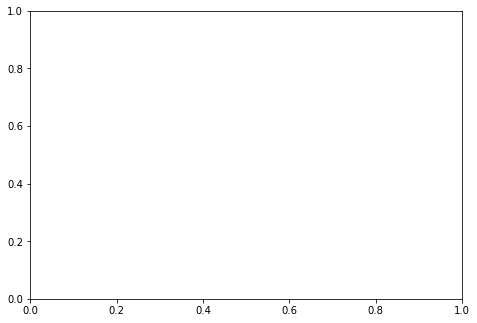

In [21]:
# generate random graph with 2000 nodes and probability 0.1
G.generateGraph(2000, 0.1, 'randomGraph', showGraph = False)

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

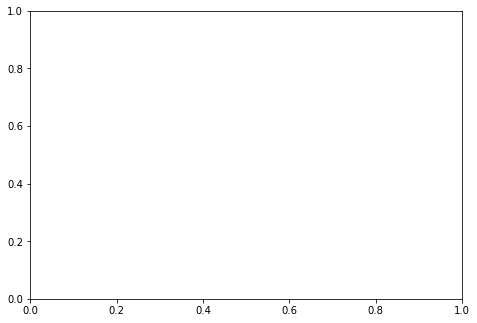

In [22]:
# generate watts strogatz graph with 2000 nodes, probability 0.1 and with k = 5
H.generateGraph(2000, 0.1, 'wattsStrogatz', showGraph = False, k = 5)

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

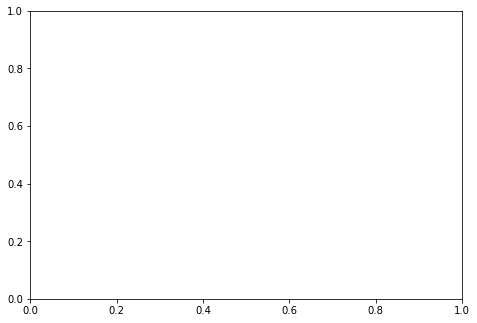

In [23]:
# generate barabasi albert graph with 2000 nodes, probability 0.1 and with m = 3 new links
I.generateGraph(2000, 0.1, 'barabasiAlbert', showGraph = False, m = 3)

In [24]:
# show number of edges and nodes for random graph
G.numberOfVerticesAndEdges()

Nodes: 2000, Edges: 379246


In [25]:
# show number of edges and nodes for watts strogatz graph
H.numberOfVerticesAndEdges()

Nodes: 2000, Edges: 4381


In [26]:
# show number of edges and nodes for barabasi albert graph
I.numberOfVerticesAndEdges()

Nodes: 2000, Edges: 5994


In [27]:
# show average degree for random graph
G.averageDegree()

Average degree is: 379.246


379.246

In [28]:
# show average degree for watts strogatz graph
H.averageDegree()

Average degree is: 4.381


4.381

In [29]:
# show average degree for barabasi albert graph
I.averageDegree()

Average degree is: 5.994


5.994

In [30]:
# show variance of degree for random graph
G.degreeDistributionVar()

Variance of a degree distribution: 296.650484


296.650484

In [31]:
# show variance of degree for watts strogatz graph
H.degreeDistributionVar()

Variance of a degree distribution: 0.3708389999999999


0.3708389999999999

In [32]:
# show variance of degree for barabasi albert graph
I.degreeDistributionVar()

Variance of a degree distribution: 52.475964


52.475964

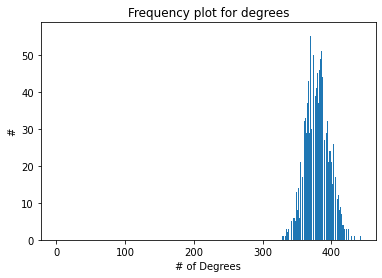

In [34]:
# plot frequencies of degrees for random graph
G.frequencyPlot()

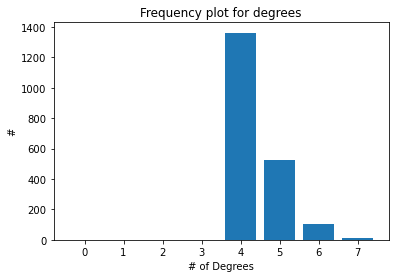

In [35]:
# plot frequencies of degrees for watts strogatz graph
H.frequencyPlot()

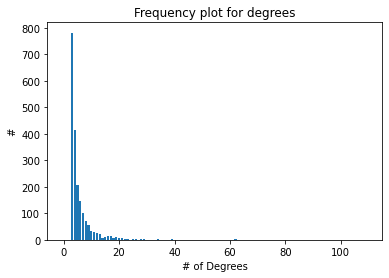

In [36]:
# plot frequencies of degrees for barabasi albert graph
I.frequencyPlot()

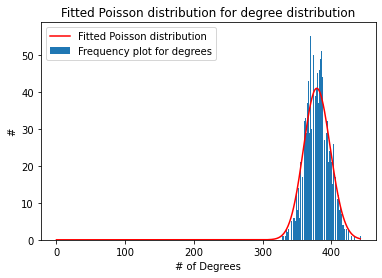

In [37]:
# fit distribution for random graph (I chose poisson)
# additionally, I know that it'd be better to be discrete not continuous, but I left it this way.
G.fitPoissonDistribution()

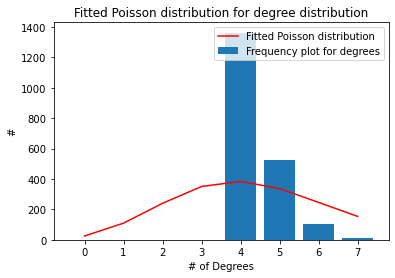

In [38]:
# fit distribution for watts strogatz graph (I chose poisson)
# additionally, I know that it'd be better to be discrete not continuous, but I left it this way.
H.fitPoissonDistribution()

C:\Users\lab\AppData\Local\Temp\ipykernel_8772\1973093836.py:175: RuntimeWarning: invalid value encountered in power
  return (alpha - 1) / xmin * (x / xmin)**(-alpha)


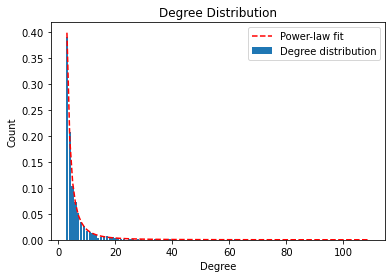

In [39]:
# fit distribution for barabasi albert graph (I chose power-law)
# additionally, I know that it'd be better to be discrete not continuous, but I left it this way.
I.fitPowerLawDistribution()